In [3]:
import cv2 as cv
import numpy as np

# 读取图片
im1 = cv.imread('1.jpg')
im2 = cv.imread('2.jpg')

# 计算SURF特征点和对应的描述子，kp存储特征点坐标，des存储对应描述子
# surf = cv.xfeatures2d.SURF_create()
# kp1, des1 = surf.detectAndCompute(im1, None)
# kp2, des2 = surf.detectAndCompute(im2, None)

# 初始化ORB
orb = cv.ORB_create()
# 寻找关键点
kp1 = orb.detect(im1)
kp2 = orb.detect(im2)
# 计算描述符
kp1, des1 = orb.compute(im1, kp1)
kp2, des2 = orb.compute(im2, kp2)


# 匹配特征点描述子
bf = cv.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)


# 提取匹配较好的特征点
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

# 通过特征点坐标计算单应性矩阵H
# （findHomography中使用了RANSAC算法剔除错误匹配）
src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)
H, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
matchesMask = mask.ravel().tolist()

# 使用单应性矩阵计算变换结果并绘图
h, w, d = im1.shape
pts = np.float32([[0,0], [0,h-1], [w-1,h-1], [w-1,0]]).reshape(-1,1,2)
dst = cv.perspectiveTransform(pts, H)
img2 = cv.polylines(im2, [np.int32(dst)], True, 255, 3, cv.LINE_AA)

draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

im3 = cv.drawMatches(im1, kp1, im2, kp2, good, None, **draw_params)
cv.imshow("Result", img2)

In [ ]:
import cv2 as cv

def ORB_Feature(img1, img2):

    # 初始化ORB
    orb = cv.ORB_create()

    # 寻找关键点
    kp1 = orb.detect(img1)
    kp2 = orb.detect(img2)

    # 计算描述符
    kp1, des1 = orb.compute(img1, kp1)
    kp2, des2 = orb.compute(img2, kp2)

    # 画出关键点
    outimg1 = cv.drawKeypoints(img1, keypoints=kp1, outImage=None)
    outimg2 = cv.drawKeypoints(img2, keypoints=kp2, outImage=None)
	
	# 显示关键点
    # import numpy as np
    # outimg3 = np.hstack([outimg1, outimg2])
    # cv.imshow("Key Points", outimg3)
    # cv.waitKey(0)

    # 初始化 BFMatcher
    bf = cv.BFMatcher(cv.NORM_HAMMING)

    # 对描述子进行匹配
    matches = bf.match(des1, des2)

    # 计算最大距离和最小距离
    min_distance = matches[0].distance
    max_distance = matches[0].distance
    for x in matches:
        if x.distance < min_distance:
            min_distance = x.distance
        if x.distance > max_distance:
            max_distance = x.distance

    # 筛选匹配点
    '''
        当描述子之间的距离大于两倍的最小距离时，认为匹配有误。
        但有时候最小距离会非常小，所以设置一个经验值30作为下限。
    '''
    good_match = []
    for x in matches:
        if x.distance <= max(2 * min_distance, 30):
            good_match.append(x)

    # 绘制匹配结果
    draw_match(img1, img2, kp1, kp2, good_match)

def draw_match(img1, img2, kp1, kp2, match):
    outimage = cv.drawMatches(img1, kp1, img2, kp2, match, outImg=None)
    cv.imshow("Match Result", outimage)
    cv.waitKey(0)

if __name__ == '__main__':
    # 读取图片
    image1 = cv.imread('1.jpg')
    image2 = cv.imread('2.jpg')
    ORB_Feature(image1, image2)


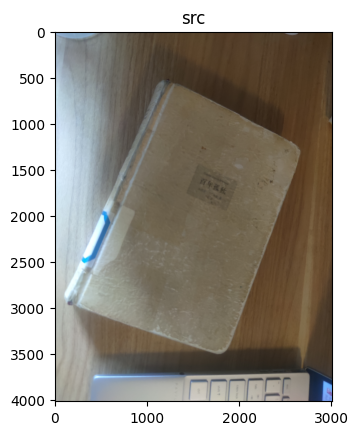

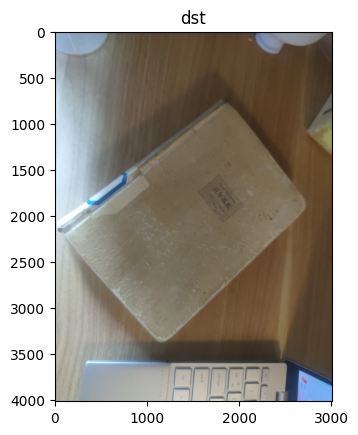

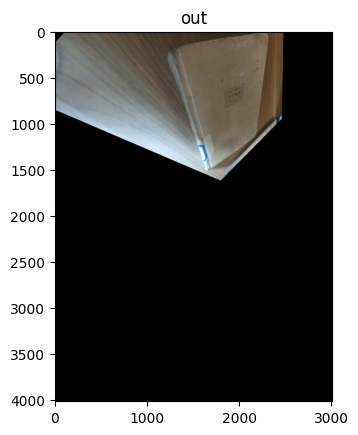

(<Figure size 640x480 with 1 Axes>,
 Text(0.5, 1.0, 'out'),
 None)

In [6]:
import cv2
import numpy as np
import pylab as pl

# Read source image.
im_src = cv2.imread('2.jpg')
# Four corners of the book in source image
pts_src = np.array([[167.0, 264.0], [482.0, 798.0], [1079.0, 403.0],[613.0, 84.0]])
# pts_src = np.array([[680, 1541], [2400, 389], [493, 630],[64, 601]])


# Read destination image.
im_dst = cv2.imread('1.jpg')
# Four corners of the book in destination image.
pts_dst = np.array([[193.0, 742.0],[996.0, 874.0],[1059.0, 157.0],[266.0, 145.0]])
# pts_dst = np.array([[1440, 3190],[800, 772],[2000, 480],[3200, 2290]])
# Calculate Homography
h, status = cv2.findHomography(pts_src, pts_dst)

# Warp source image to destination based on homography
im_out = cv2.warpPerspective(im_src, h, (im_dst.shape[1],im_dst.shape[0]))

pl.figure(), pl.imshow(im_src[:, :, ::-1]), pl.title('src'),
pl.figure(), pl.imshow(im_dst[:, :, ::-1]), pl.title('dst')
pl.figure(), pl.imshow(im_out[:, :, ::-1]), pl.title('out'), pl.show()  #show dst